In [1]:
!pip install opencv-python==4.12.0.88 mediapipe==0.10.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


## Pose Detection 부분

In [2]:
import math
import cv2
import numpy as np
from time import time
from mediapipe.python.solutions import pose as mp_pose
from mediapipe.python.solutions import drawing_utils as mp_drawing
import matplotlib.pyplot as plt

In [3]:
POSE_MODEL = mp_pose.Pose(
    static_image_mode=True,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.6,
    model_complexity=2
)

In [4]:
## Pose detection - Improved Version

def detectPose_improve(image, pose, display=True):

    # 이미지 복사
    output_image = image.copy()

    # BGR → RGB 변환
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Pose detection 수행
    results = pose.process(imageRGB)

    # 이미지 크기
    height, width, _ = image.shape

    # landmark 리스트 초기화
    landmarks = []

    # landmark 감지 시
    if results.pose_landmarks:

        # landmark 그리기
        mp_drawing.draw_landmarks(
            image=output_image,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS
        )

        # landmark 좌표 저장
        for landmark in results.pose_landmarks.landmark:
            lx = int(landmark.x * width)
            ly = int(landmark.y * height)
            lz = landmark.z
            landmarks.append((lx, ly, lz))

    # 화면 출력 모드일 때
    if display:

        # 원본 및 결과 비교 시각화
        plt.figure(figsize=[22, 22])
        plt.subplot(121)
        plt.imshow(image[:, :, ::-1])
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(output_image[:, :, ::-1])
        plt.title("Output Image")
        plt.axis('off')

        # 안전한 3D world landmark 출력
        if results.pose_world_landmarks:
            mp_drawing.plot_landmarks(
                results.pose_world_landmarks,
                mp_pose.POSE_CONNECTIONS,
                azimuth=45
            )
        else:
            print("World landmarks not detected.")

    # display=False일 때는 return
    return output_image, landmarks

## 의류 피팅용 핵심 랜드마크만 추출

In [5]:
# 상·하의 피팅 기준 핵심 landmark
KEY_LANDMARKS = {
    # 얼굴 기준점 (정렬용)
    "nose": 0,

    # 상의 (어깨, 팔)
    "left_shoulder": 11,
    "right_shoulder": 12,
    "left_elbow": 13,
    "right_elbow": 14,
    "left_wrist": 15,
    "right_wrist": 16,

    # 하의 (골반, 다리)
    "left_hip": 23,
    "right_hip": 24,
    "left_knee": 25,
    "right_knee": 26,
    "left_ankle": 27,
    "right_ankle": 28
}

In [6]:
def extract_key_landmarks(landmarks):

    key_points = {}

    for name, idx in KEY_LANDMARKS.items():
        lx, ly, lz = landmarks[idx]
        key_points[name] = (lx, ly, lz)

    return key_points

In [7]:
# 핵심 랜드마크만 추출하는 함수
# pose detection 수행
def detectClothingPose(image, pose, display=True):
    """
    의류 피팅용 핵심 landmark만 추출하는 함수.
    - 원본 이미지에서 pose detection 수행
    - 핵심 12개 landmark만 dict로 반환
    """

    output_image = image.copy()
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = pose.process(img_rgb)

    height, width, _ = image.shape
    all_landmarks = []

    # 랜드마크 감지되었을 때
    if results.pose_landmarks:

        # 그림 그리기
        mp_drawing.draw_landmarks(
            output_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS
        )

        # 33개 전체 landmark 추출
        for lm in results.pose_landmarks.landmark:
            x = int(lm.x * width)
            y = int(lm.y * height)
            z = lm.z          # z는 scale하지 않는 것이 좋음
            all_landmarks.append((x, y, z))

        # ---- 핵심 12개 landmark만 추출 ----
        keypoints = extract_key_landmarks(all_landmarks)

    else:
        keypoints = None

    # 디스플레이 모드
    if display:
        plt.figure(figsize=[20, 20])
        plt.subplot(121)
        plt.title("Original")
        plt.axis("off")
        plt.imshow(image[:, :, ::-1])

        plt.subplot(122)
        plt.title("Pose Output")
        plt.axis("off")
        plt.imshow(output_image[:, :, ::-1])

        # 3D world landmark가 존재하면 표시
        if results.pose_world_landmarks:
            mp_drawing.plot_landmarks(
                results.pose_world_landmarks,
                mp_pose.POSE_CONNECTIONS,
                azimuth=45
            )
        else:
            print("World landmarks not detected.")

    return output_image, keypoints

## 적용

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
woman_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_front.jpg')
woman_back = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_back.jpg')
woman_left = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_left.jpg')
woman_right = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Woman_whole_body_right.jpg')

man_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/Man_whole_body_front.jpg')
woman2_front = cv2.imread('/content/drive/MyDrive/컴비 팀플/data/인물/WOMEN-Tees_Tanks-id_00004269-04_1_front.jpg')

image = woman_front

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


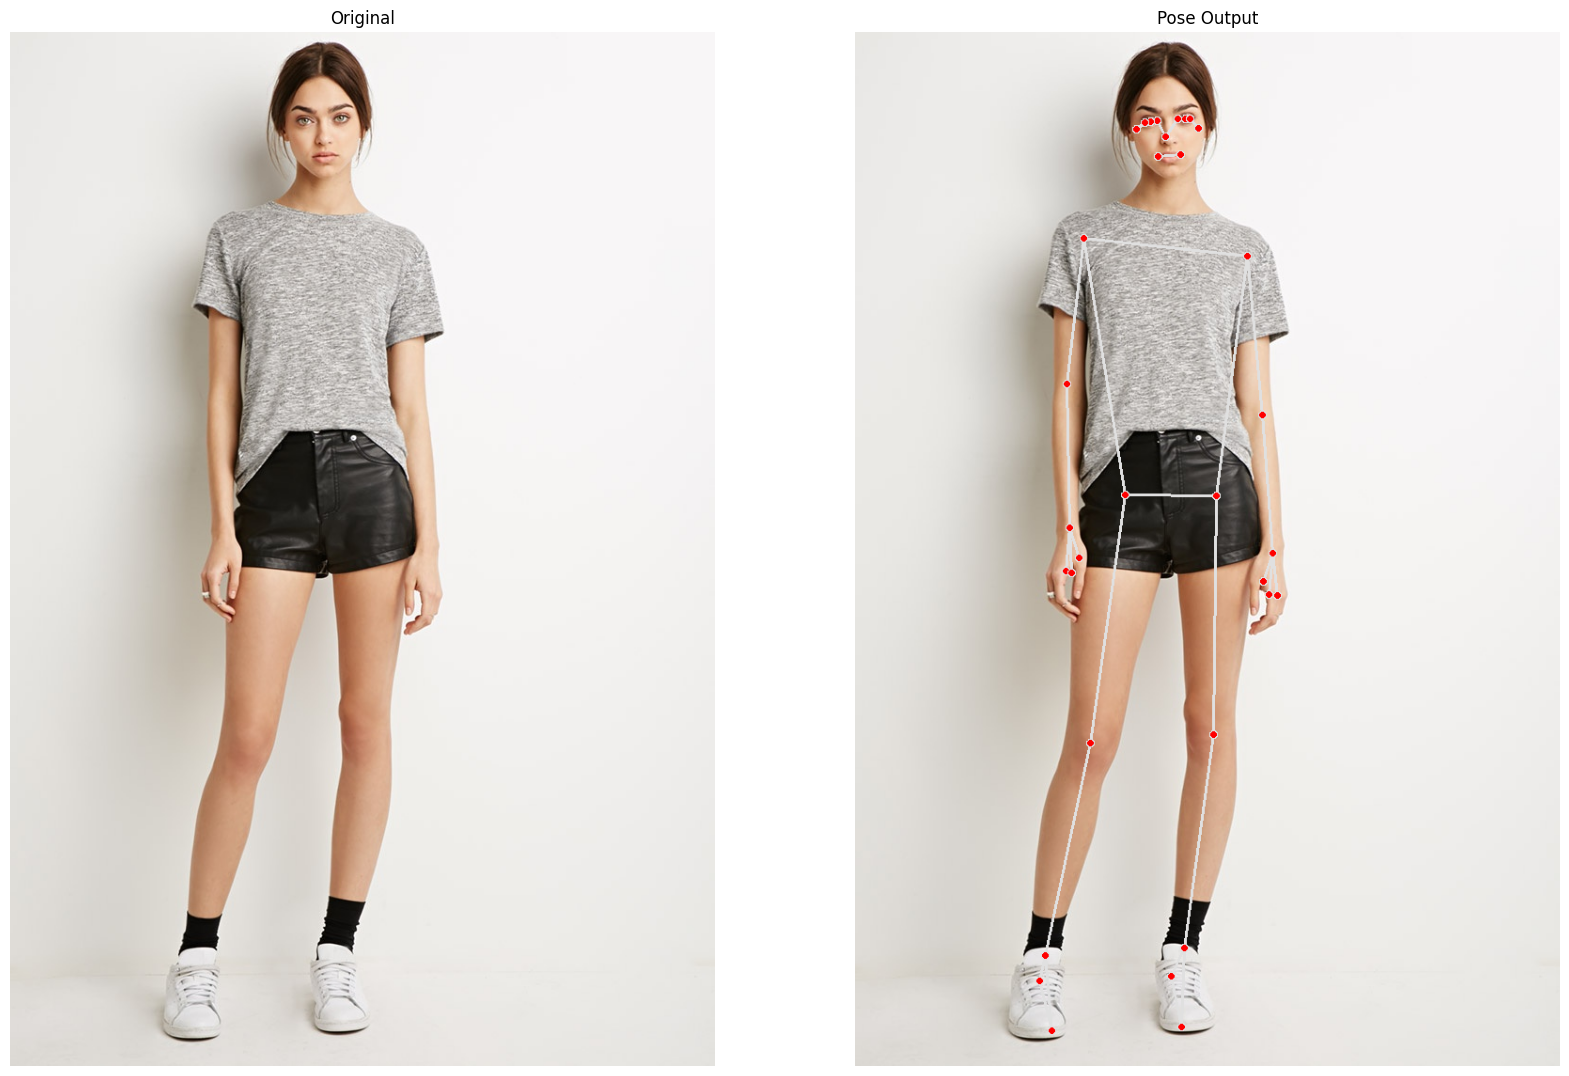

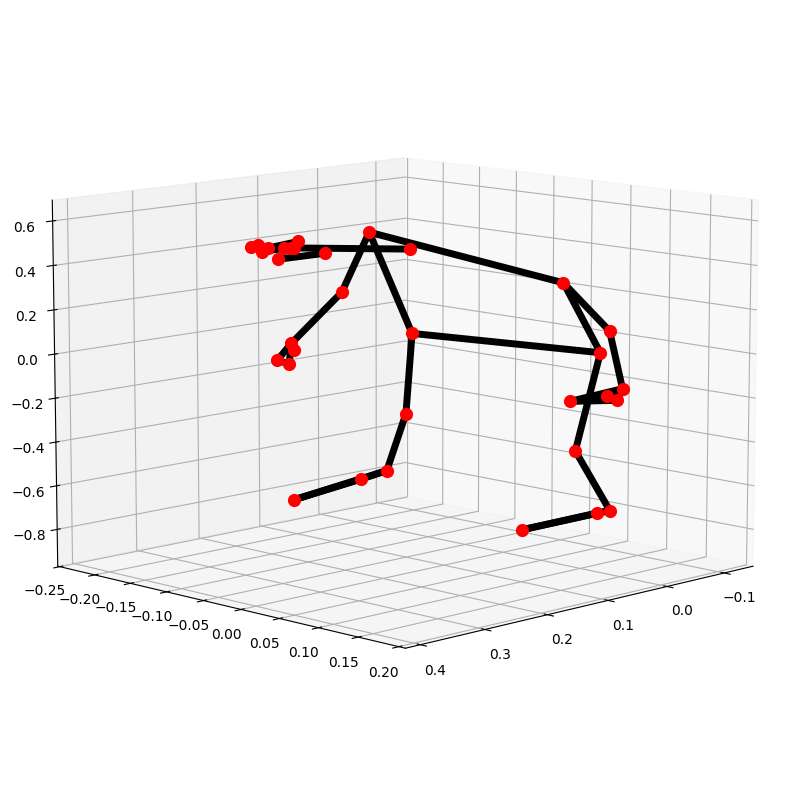

In [10]:
output_image, keypoints = detectClothingPose(image, POSE_MODEL, display=True)

In [11]:
print(keypoints)

{'nose': (330, 112, -0.8634363412857056), 'left_shoulder': (417, 239, -0.2433411180973053), 'right_shoulder': (243, 220, -0.33799421787261963), 'left_elbow': (433, 408, -0.09703671932220459), 'right_elbow': (225, 375, -0.28808319568634033), 'left_wrist': (444, 555, -0.3520793318748474), 'right_wrist': (228, 528, -0.5446163415908813), 'left_hip': (384, 494, 0.05208645015954971), 'right_hip': (287, 493, -0.052738454192876816), 'left_knee': (381, 748, 0.021113669499754906), 'right_knee': (250, 757, -0.1211613193154335), 'left_ankle': (350, 975, 0.2882383167743683), 'right_ankle': (202, 983, 0.07894885540008545)}


## Warping (사람 + 옷)

### 1. 템플릿 JSON(size.json) 로드

In [12]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

TEMPLATE_JSON_PATH = "/content/drive/MyDrive/컴비 팀플/data/size.json"

with open(TEMPLATE_JSON_PATH, "r", encoding="utf-8") as f:
    CLOTH_TEMPLATES = json.load(f)

print("불러온 템플릿 ID들:", list(CLOTH_TEMPLATES.keys()))
# 예: ['hoodie_1', 'jeans_1', 'gown_1']


불러온 템플릿 ID들: ['hoodie_1', 'panjang_1', 'gown_1', 'hoodie_2', 'panjang_2', 'gown_2', 'hoodie_3', 'panjang_3', 'gown_3']


### 2. Warping 유틸 함수들

In [13]:
def ensure_bgra(cloth_img):
    """3채널이면 알파 채널(255)을 추가해서 BGRA로 맞춰줌."""
    if cloth_img is None:
        raise ValueError("cloth_img 가 None 입니다. 경로를 확인하세요.")
    if cloth_img.shape[2] == 4:
        return cloth_img
    b, g, r = cv2.split(cloth_img)
    a = np.full_like(b, 255)
    return cv2.merge([b, g, r, a])


def get_src_dst_points_from_template(cloth_meta, keypoints):
    """
    size.json 의 anchors(옷 좌표)와
    pose keypoints(사람 좌표)를 매칭해서
    src_pts(옷), dst_pts(사람) 배열을 만들기
    """
    src_pts, dst_pts = [], []

    for name, pos in cloth_meta["anchors"].items():
        if name not in keypoints:
            # 이 키포인트는 pose에서 못 찾았으면 스킵
            continue

        cx, cy = pos              # 옷 이미지 안에서의 anchor
        px, py, _ = keypoints[name]  # 사람 이미지 안에서의 keypoint

        src_pts.append([cx, cy])
        dst_pts.append([px, py])

    src_pts = np.float32(src_pts)
    dst_pts = np.float32(dst_pts)

    if len(src_pts) < 3:
        raise ValueError(f"매칭 가능한 포인트가 3개 미만입니다. anchors: {cloth_meta['anchors'].keys()}")

    return src_pts, dst_pts


def fit_cloth_with_template(person_img_bgr, keypoints, cloth_img, cloth_meta):
    """
    - person_img_bgr : 사람 원본 이미지 (BGR)
    - keypoints      : detectClothingPose() 에서 얻은 포즈 키포인트 dict
    - cloth_img      : 옷 PNG (BGR 또는 BGRA)
    - cloth_meta     : size.json 에서 읽은 해당 옷 템플릿(dict)
    """
    ph, pw = person_img_bgr.shape[:2]
    cloth_bgra = ensure_bgra(cloth_img)

    src_pts, dst_pts = get_src_dst_points_from_template(cloth_meta, keypoints)

    # Affine 변환 행렬 추정
    M, _ = cv2.estimateAffine2D(src_pts, dst_pts)

    # 옷을 사람 이미지 크기에 맞게 warp
    warped = cv2.warpAffine(
        cloth_bgra, M, (pw, ph),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0, 0)
    )

    # 알파 블렌딩
    wb, wg, wr, wa = cv2.split(warped)
    cloth_rgb = cv2.merge([wb, wg, wr])
    alpha = wa.astype(np.float32) / 255.0
    alpha_3 = cv2.merge([alpha, alpha, alpha])

    base = person_img_bgr.astype(np.float32)
    out = cloth_rgb.astype(np.float32) * alpha_3 + base * (1.0 - alpha_3)
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out


### 3. 템플릿 ID로 바로 피팅하는 함수

In [14]:
def fit_from_template_id(person_img_bgr, keypoints, template_id):
    """
    template_id: size.json 에 정의한 키 이름 (예: 'hoodie_1', 'jeans_1', 'gown_1')
    """
    if template_id not in CLOTH_TEMPLATES:
        raise KeyError(f"size.json 에 '{template_id}' 템플릿이 없습니다.")

    meta = CLOTH_TEMPLATES[template_id]
    img_path = meta["image_path"]

    cloth_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if cloth_img is None:
        raise FileNotFoundError(f"옷 이미지를 찾을 수 없습니다: {img_path}")

    result = fit_cloth_with_template(person_img_bgr, keypoints, cloth_img, meta)
    return result


### 4. 적용: 상의 / 하의 / 원피스 각각 + 오리지널 (4장 시각화)

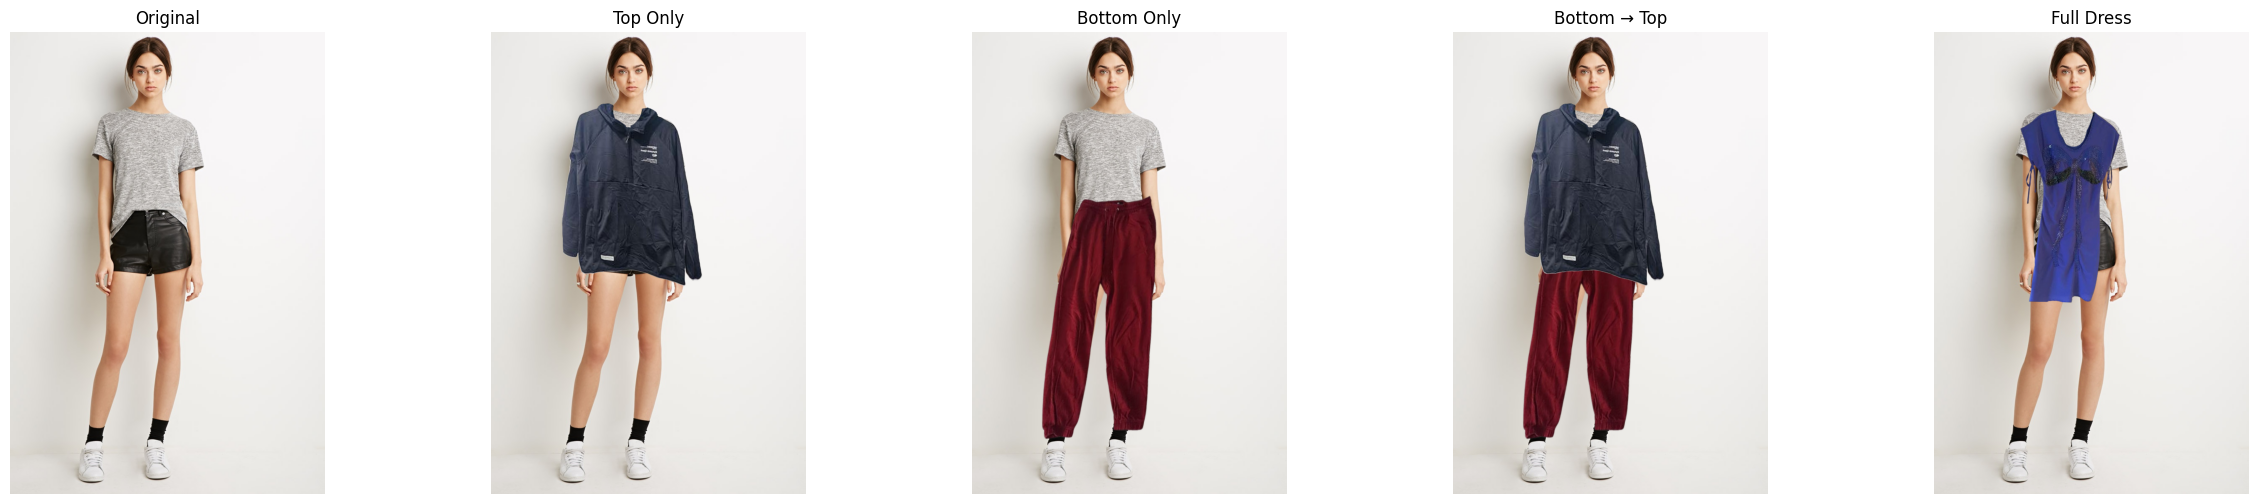

In [18]:
# 1) 포즈 추출
pose_output, keypoints = detectClothingPose(image, POSE_MODEL, display=False)

# 2) 상의 / 하의 / 원피스 각각 입히기
result_top = fit_from_template_id(
    image,
    keypoints,
    template_id="hoodie_1"    # 상의 템플릿 키
)

result_bottom = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_1"   # 하의 템플릿 키
)

result_full = fit_from_template_id(
    image,
    keypoints,
    template_id="gown_1"      # 원피스/가운 템플릿 키
)

# 2-1) 상의 + 하의 버전 (하의 먼저 → 상의 나중)
result_both = fit_from_template_id(
    image,
    keypoints,
    template_id="panjang_1"   # 먼저 하의
)
result_both = fit_from_template_id(
    result_both,
    keypoints,
    template_id="hoodie_1"    # 그 위에 상의
)

# 3) 결과 시각화
plt.figure(figsize=(30, 6))

plt.subplot(151)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(152)
plt.imshow(cv2.cvtColor(result_top, cv2.COLOR_BGR2RGB))
plt.title("Top Only")
plt.axis("off")

plt.subplot(153)
plt.imshow(cv2.cvtColor(result_bottom, cv2.COLOR_BGR2RGB))
plt.title("Bottom Only")
plt.axis("off")

plt.subplot(154)
plt.imshow(cv2.cvtColor(result_both, cv2.COLOR_BGR2RGB))
plt.title("Bottom → Top")
plt.axis("off")

plt.subplot(155)
plt.imshow(cv2.cvtColor(result_full, cv2.COLOR_BGR2RGB))
plt.title("Full Dress")
plt.axis("off")

plt.show()
